## AI-rmonizer. Spectra-driven unsupervised composition system.
### MIDI activation score: Bach's Cello Suite No.1

Download the MIDI trigger: http://www.jsbach.net/midi/midi_solo_cello.html

Download the Weights: https://zenodo.org/record/8342535
#### ACKNOWLEDGMENT
This work is based on data from the MILES service developed by the Spanish Virtual Observatory in the framework of the IAU Comission G5 Working Group : Spectral Stellar Libraries.

In [1]:
import os
import pickle
import numpy as np
from music21 import *#note, chord, corpus, converter, stream, instrument
import glob
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

## Loading Bach's Trigger

In [3]:
data_dir = '## YOUR FOLDER PATH TO THE DOWNLOADED MIDI ##'

# list of files
midi_list = os.listdir(data_dir)

# Load and make list of stream objects
test_scores = []
for midi in tqdm(midi_list):
    score = converter.parse(os.path.join(data_dir,midi))
    test_scores.append(score)

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
midi_list

['cs1-1pre.mid']

In [5]:
test_scores = [midi.chordify() for midi in tqdm(test_scores)]

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Define empty lists of lists
test_chords = [[] for _ in test_scores]
test_durations = [[] for _ in test_scores]
test_keys = []

# Extract notes, chords, durations, and keys
for i, midi in tqdm(enumerate(test_scores)):
    test_keys.append(str(midi.analyze('key')))
    for element in midi:
        if isinstance(element, note.Note):
            test_chords[i].append(element.pitch)
            test_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            test_chords[i].append('.'.join(str(n) for n in element.pitches))
            test_durations[i].append(element.duration.quarterLength)

0it [00:00, ?it/s]

In [7]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [8]:
store_folder = 'parsed_data_Bach'
os.mkdir(store_folder)

In [9]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct([n for chord in test_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in test_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [10]:
# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [11]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=29 and Duration values=4


## Building up 'initial_chords' via 'train_chords'

In [12]:
# Set sequence length
sequence_length = 300

# Define empty array for train data
train_chords = []
train_durations = []
# Construct train and target sequences for chords and durations
for s in range(len(test_chords)):
    chord_list = [note_to_int[c] for c in test_chords[s]]# 'chord_list' codification with 'note to int'
    duration_list = [duration_to_int[d] for d in test_durations[s]]# duration codification with 'duration to int'
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])

In [13]:
train_chords = np.array(train_chords)
train_durations = np.array(train_durations)

## Building up the pretrained Model

In [14]:
def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256):
    """ create the structure of the neural network """

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=RMSprop(learning_rate= 0.001))#before "lr=0.001"

    return model

In [15]:
embed_size = 128
rnn_units = 128

In [16]:
model = create_network(82231, 118, embed_size, rnn_units)

2023-05-11 20:45:38.872089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    10525568    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    15104       ['input_2[0][0]']                
                                                                                              

In [18]:
model.load_weights('## YOUR PATH TO Weights_AI-rmonizer.h5 ##')

# Generating Music

In [19]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [20]:
# chord and duration sequences
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [21]:
# Function to predict chords and durations
def predict_chords(chord_sequence, duration_sequence,model,temperature=0.8):
    predicted_chords, predicted_durations = model.predict([chord_sequence, duration_sequence])
    return sample_with_temp(predicted_chords[0],temperature), sample_with_temp(predicted_durations[0],temperature)

In [22]:
# https://numpy.org/doc/stable/user/quickstart.html
# Define empty lists for generated chords and durations
new_chords, new_durations = [], []

# Generate chords and durations using 50 rounds of prediction
for j in range(sequence_length-1): #50
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

1/1 [==============================] - 0s 37ms/step


/var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/ipykernel_1120/349567576.py:6: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


1/1 [==============================] - 0s 34ms/step


# Solving lack of new chords and durations generated 

In [24]:
original_chords = np.load('## YOUR PATH TO original_chords_MAESTRO.npy ##', allow_pickle=True)
original_durations = np.load('## YOUR PATH TO original_durations_MAESTRO.npy ##', allow_pickle=True)

In [25]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct([n for chord in original_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in original_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [26]:
# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [27]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=82231 and Duration values=118


In [28]:
durations_OK = new_durations
for i in range(len(new_durations)):
    try:
        durations_OK[i]= int_to_duration[new_durations[i]]
    except:
        durations_OK[i]=0.25

In [29]:
for i in range(len(new_durations)):
    print(durations_OK[i])

1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12
1/12


In [30]:
durations_OK = np.array(durations_OK, dtype=float)

# Generating music score

In [32]:
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())
#----------------------------------------------------------MODIFICATIONS TO MAKE THE DURATIONS WORK

dur_notes = ["whole","half", "quarter", "eighth"]#, "16th"]#, "32nd", "64th"]

for j in range(len(new_chords)):
    
    if durations_OK[j] > 2:
        figure = dur_notes[0]
    if (durations_OK[j] > 1) and (durations_OK[j] <= 2):
        figure = dur_notes[1]
    if (durations_OK[j] > 0.5) and (durations_OK[j] <= 1):
        figure = dur_notes[2]
    if durations_OK[j] <= 0.5:
        figure = dur_notes[3]
      
    
    
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          type = figure))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                          type = figure))

# Export as MIDI file
midi_score = generated_stream.write('midi', fp='lstm_Maestro_Bach_200Ep.mid')

In [33]:
midi_score = converter.parse('lstm_Maestro_Bach_200Ep.mid').chordify()

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): no suitable image found.  Did find:
	/usr/local/lib/libjack.0.dylib: code signature in (/usr/local/lib/libjack.0.dylib) not valid for use in process using Library Validation: mapped file has no cdhash, completely unsigned? Code has to be at least ad-hoc signed. 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpab3wwyql.xml>...
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpab3wwyql.png>
... success!


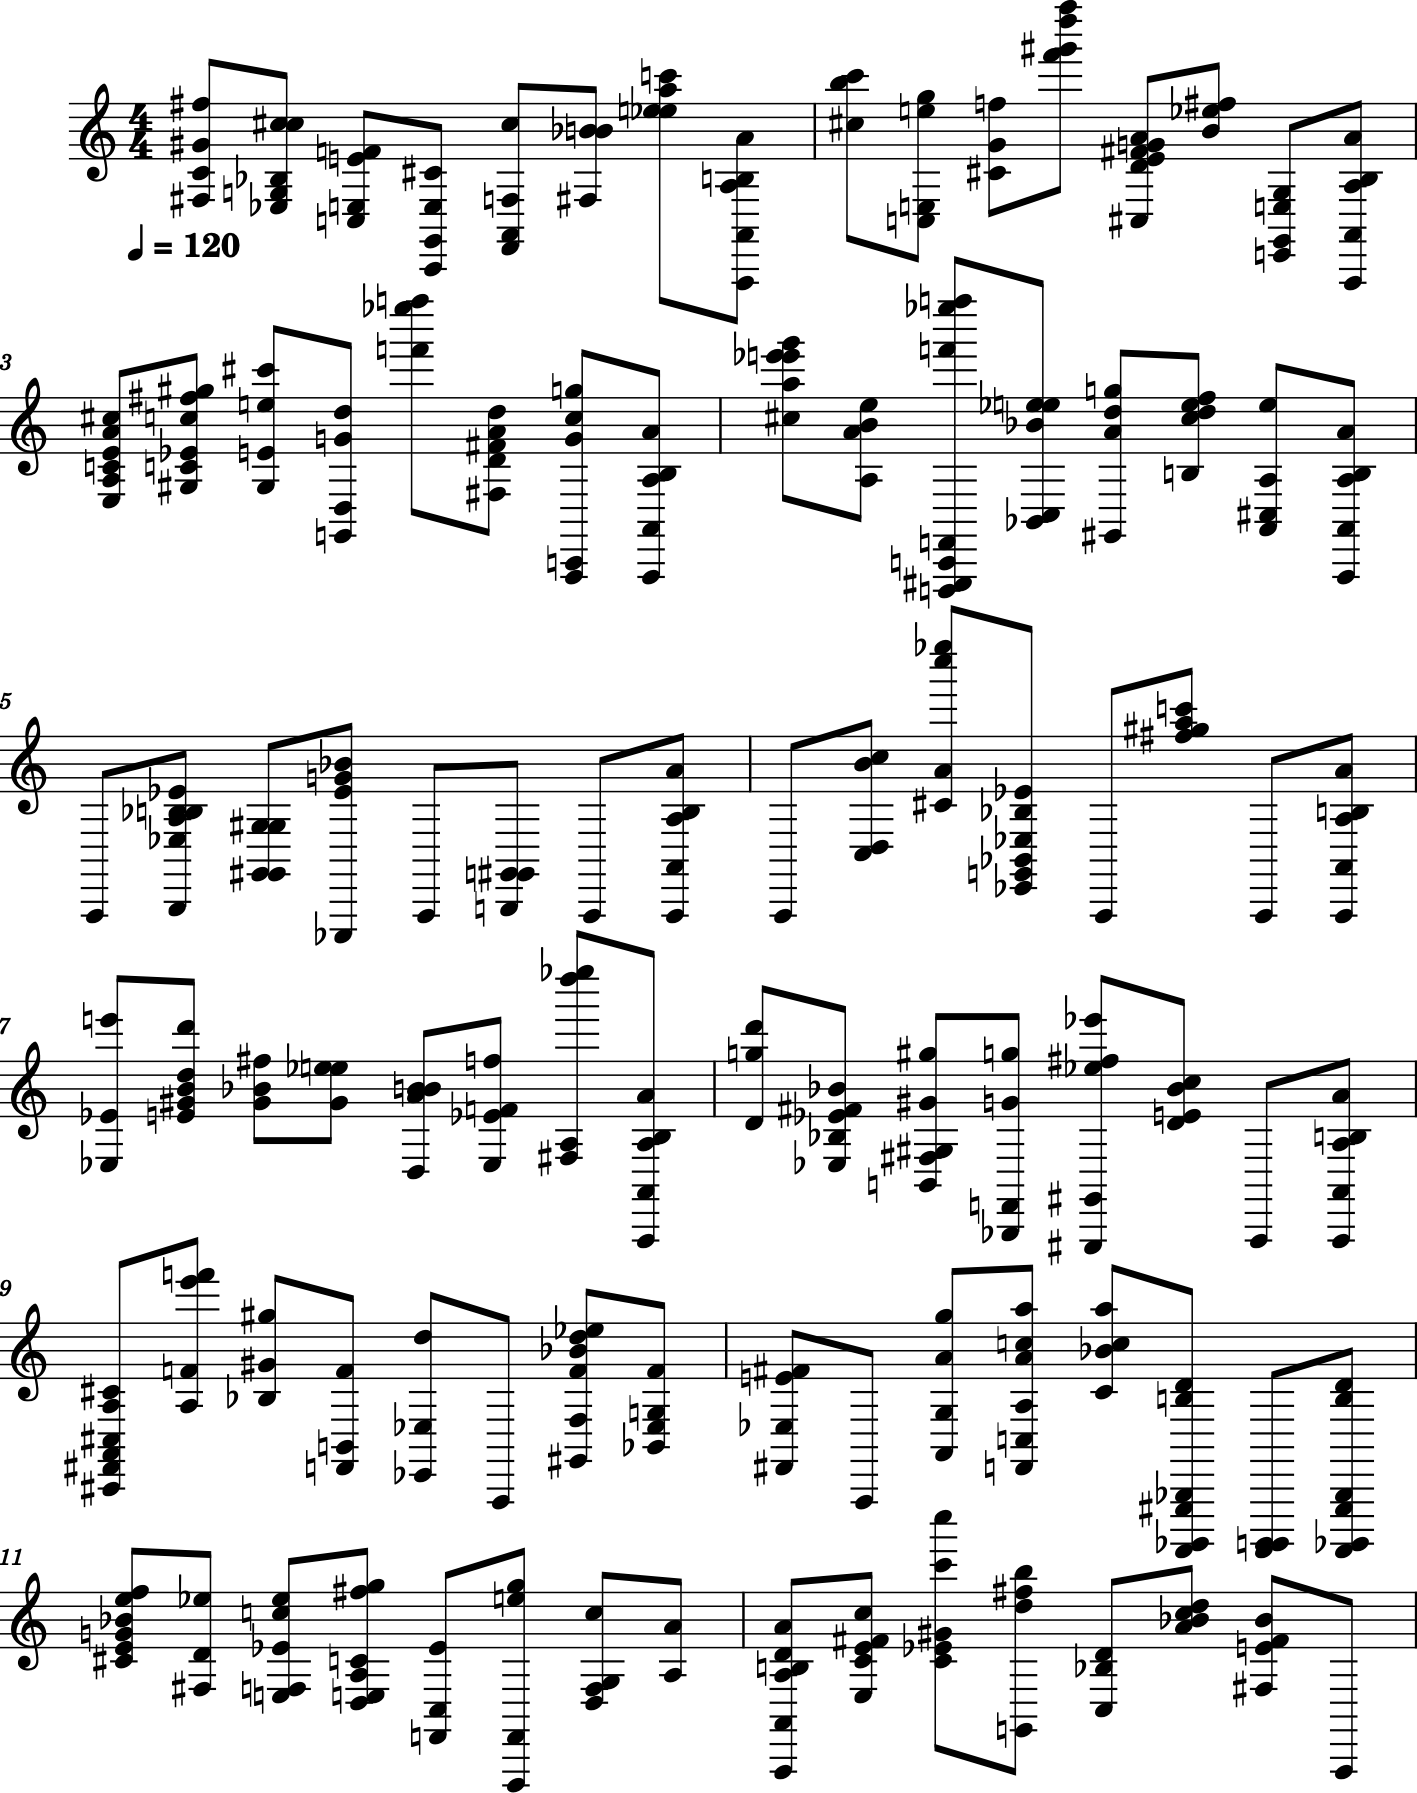

In [34]:
midi_score.show()

In [35]:
midi_score.show('midi')

In [36]:
new_chords_OK = new_chords
for j in range(len(new_chords)):
    new_chords_OK[j] = int_to_note[new_chords[j]].replace('.', ' ')

In [37]:
np.save('new_chords_OK', new_chords_OK)

In [38]:
np.save('new_durations', new_durations)

# Pitch Class Set Theory crossmatch

In [39]:
import matplotlib.pyplot as plt
import math
from math import log2, pow

In [40]:
spectra_chords = np.load('## YOUR PATH TO spectra_chords.npy ##')
spectra_durations = np.load('## YOUR PATH TO spectra_durations.npy ##')

In [41]:
spectra_strings = np.array(['A0' for _ in range(len(spectra_chords))], dtype=object)

In [42]:
for i in range(len(spectra_chords)):
    spectra_strings[i] = (spectra_chords[i][0] + ' ' + spectra_chords[i][1] + ' ' + spectra_chords[i][2]+ ' ' + spectra_chords[i][3])

In [43]:
final_chords = np.array(['A0' for _ in range(len(new_chords))], dtype=object)

In [44]:
for i in range(len(new_chords)):
    for j in range(len(spectra_strings)):
        if spectra_strings[j] == new_chords[i]:
            final_chords[i] = spectra_strings[j]

In [45]:
new_chords_OK

['F#3 C4 G#4 F#5',
 'E-3 G3 B-3 C5 C#5',
 'C3 E3 E4 F4',
 'C2 G2 E3 C#4',
 'F2 A2 F3 C#5',
 'F#3 B-4 B4',
 'E-5 E5 A5 C6',
 'A1 A2 A3 B3 A4',
 'C#5 B5 C6',
 'C3 E3 E5 G5',
 'C#4 G4 F5',
 'F6 G#6 D7 F7',
 'C#3 D4 E4 F#4 G4 A4',
 'B4 E-5 F#5',
 'E2 G2 E3 G3',
 'A1 A2 A3 B3 A4',
 'E3 A3 C4 E4 A4 C#5',
 'G#3 C4 E-4 C5 F#5 G#5',
 'G#3 E4 E5 C#6',
 'G2 D3 G4 D5',
 'F6 E-7 F7',
 'F#3 D4 F#4 A4 D5',
 'A1 C2 G4 C5 G5',
 'A1 A2 A3 B3 A4',
 'C#5 A5 E-6 E6 G6',
 'A3 A4 B4 E5',
 'F1 G#1 C2 F2 F6 E-7 F7',
 'B-2 C3 B-4 E-5 E5',
 'G#2 A4 D5 G5',
 'B3 C#5 D5 E5 F5',
 'A2 C#3 A3 E5',
 'A1 A2 A3 B3 A4',
 'A1',
 'B1 E-3 A3 B-3 B3 E-4',
 'G2 G#2 G3 G#3',
 'E-1 E-4 G4 B-4',
 'A1',
 'B1 G2 G#2',
 'A1',
 'A1 A2 A3 B3 A4',
 'A1',
 'C3 D3 B4 C5',
 'C#4 A4 C7 E-7',
 'E-2 G2 B-2 E-3 B-3 E-4',
 'A1',
 'F#5 G#5 A5 C6',
 'A1',
 'A1 A2 A3 B3 A4',
 'E-3 E-4 E6',
 'E4 G#4 B4 D5 D6',
 'G#4 B-4 F#5',
 'G#4 E-5 E5',
 'D3 A4 B-4 B4',
 'E-3 E-4 F4 F5',
 'F#3 A3 D7 E-7',
 'A1 A2 A3 B3 A4',
 'D4 G5 D6',
 'E-3 B-3 E-4 F#4 B-4'

In [46]:
spectra_reff = np.zeros(len(new_chords), dtype=int)
for i in range(len(new_chords)):
    for j in range(len(spectra_strings)):
        try:
            chord1 = chord.Chord(new_chords[i])
            chord2 = chord.Chord(spectra_chords[j])
            if chord2.orderedPitchClassesString == chord1.orderedPitchClassesString:
                final_chords[i] = spectra_strings[j]
                spectra_reff[i] = j
        except:
            print(j)
            j=len(spectra_strings)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [47]:
np.save('spectra_reff', spectra_reff)

# Generating stellar score

In [49]:
generated_stellar_stream = stream.Stream()
generated_stellar_stream.append(instrument.Piano())

dur__stellar_notes = ["whole","half", "quarter", "eighth"]#, "16th"]#, "32nd", "64th"]

for j in range(len(final_chords)):
    
    if spectra_durations[spectra_reff[j]] > 2:
        figure = dur_notes[0]
    if (spectra_durations[spectra_reff[j]] > 1) and (spectra_durations[spectra_reff[j]] <= 2):
        figure = dur_notes[1]
    if (spectra_durations[spectra_reff[j]] > 0.5) and (spectra_durations[spectra_reff[j]] <= 1):
        figure = dur_notes[2]
    if spectra_durations[spectra_reff[j]] <= 0.5:
        figure = dur_notes[3]
      
    
    if final_chords[j] == 'A0':
        generated_stellar_stream.append(note.Rest(final_chords[j], type = figure))

    else:
        try:
            generated_stellar_stream.append(note.Note(final_chords[j], type = figure))
        except:
            generated_stellar_stream.append(chord.Chord(final_chords[j], type = figure))

# Export as MIDI file
midi_stellar_score = generated_stellar_stream.write('midi', fp='Maestro_Bach_stellar_composition.mid')

In [50]:
midi_score = converter.parse('Maestro_Bach_stellar_composition.mid').chordify()

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): no suitable image found.  Did find:
	/usr/local/lib/libjack.0.dylib: code signature in (/usr/local/lib/libjack.0.dylib) not valid for use in process using Library Validation: mapped file has no cdhash, completely unsigned? Code has to be at least ad-hoc signed. 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpzce5qaho.xml>...
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpzce5qaho.png>
... success!


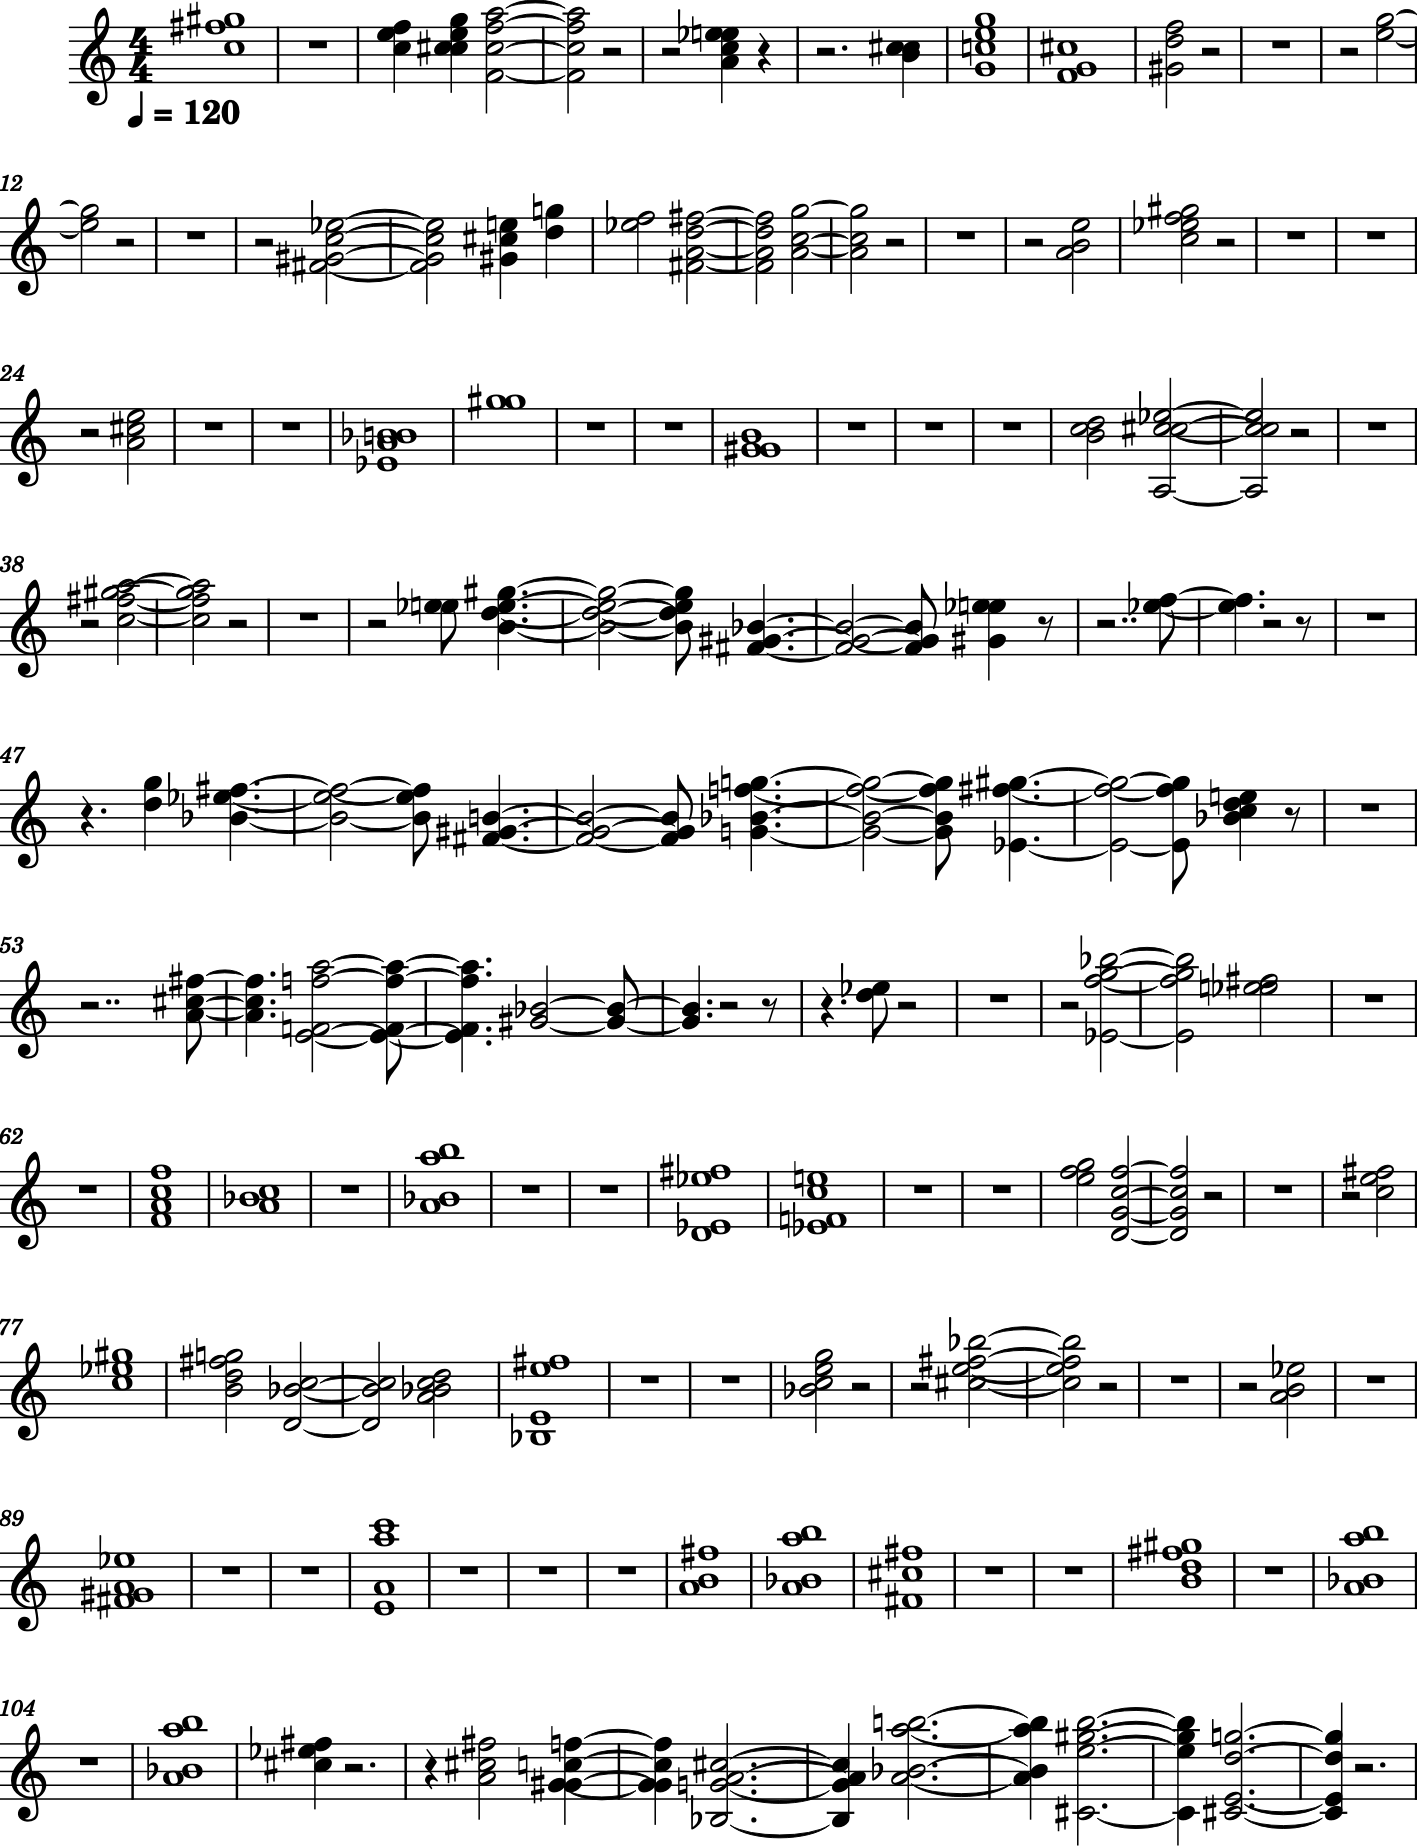

In [51]:
midi_score.show()

In [52]:
midi_score.show('midi')

# Generating the final Polyphonic Stellar Score

In [53]:
np.save('final_chords_Maestro_Bach', final_chords)

In [54]:
string_notes = final_chords

In [55]:
for i in range(len(string_notes)):
    if string_notes[i] == "A0":
        string_notes[i] = "A0 A0 A0 A0"

In [56]:
encoded_notes = np.empty([len(string_notes), 4], dtype=object)

for i in range(len(string_notes)):
    notes = string_notes[i].split()
    notes = np.array(notes)
    for j in range(len(notes)):
        encoded_notes[i][j] = notes[j]

In [57]:
dim = len(string_notes)

In [58]:
chords = [[] for _ in encoded_notes]
for i in range(dim):
    for j in range(4):
        chords[i].append(encoded_notes[i][j])

In [59]:
import random
score = stream.Score()
n = 120
score.append(tempo.MetronomeMark(number=n))

a = stream.Part()
a.append(tempo.MetronomeMark(number=n))
score.insert(0,a)


b = stream.Part()
b.append(tempo.MetronomeMark(number=n))
score.insert(1,b)

c = stream.Part()
c.append(tempo.MetronomeMark(number=n))
score.insert(2,c)

d = stream.Part()
d.append(tempo.MetronomeMark(number=n))
score.insert(3,d)

In [60]:
durations = ["whole","half", "quarter", "eighth", "dottedHalf"]#, "16th"]#, "32nd", "64th"]
for i in range(len(chords)):
      
    if spectra_durations[spectra_reff[i]] > 2:
        figure = 0
    if ((spectra_durations[spectra_reff[i]] > 1) & (spectra_durations[spectra_reff[i]] <= 2)):
        figure = 1
    if ((spectra_durations[spectra_reff[i]] > 0.5) & (spectra_durations[spectra_reff[i]] <= 1)):
        figure = 2
    if spectra_durations[spectra_reff[i]] <= 0.5:
        figure = 3

    exec(f'm{i} = note.Note(chords[i][0])')
    exec(f'm{i}.duration.type = durations[figure]')
    
    exec(f'n{i} = note.Note(chords[i][1])')
    exec(f'n{i}.duration.type = durations[figure]')
    
    exec(f'o{i} = note.Note(chords[i][2])')
    exec(f'o{i}.duration.type = durations[figure]')
    
    exec(f'p{i} = note.Note(chords[i][3])')
    exec(f'p{i}.duration.type = durations[figure]')
    
    if chords[i][0] == "A0":
        exec(f'm{i} = note.Rest(chords[i][0], quarterLength= 3)')
        
        exec(f'n{i} = note.Rest(chords[i][0], quarterLength= 3)')
        
        exec(f'o{i} = note.Rest(chords[i][0], quarterLength= 3)')
        
        exec(f'p{i} = note.Rest(chords[i][0], quarterLength= 3)')

In [61]:
for k in range(dim):
    if chords[k][0] != "A0": #Omiting silences TEST
        exec(f'a.append(n{k})')
        exec(f'b.append(m{k})')
        exec(f'c.append(o{k})')
        exec(f'd.append(p{k})')
#     if (chords[k][0] == "A0") and (chords[k-1][0] != "A0"): #Only one silence
 #       exec(f'a.append(n{k})')
  #      exec(f'b.append(m{k})')
   #     exec(f'c.append(o{k})')
    #    exec(f'd.append(p{k})')

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): no suitable image found.  Did find:
	/usr/local/lib/libjack.0.dylib: code signature in (/usr/local/lib/libjack.0.dylib) not valid for use in process using Library Validation: mapped file has no cdhash, completely unsigned? Code has to be at least ad-hoc signed. 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpix7o1oit.xml>...
Error at line 3458 col 18: duplicate tempo at tick 0
Error at line 6841 col 18: duplicate tempo at tick 0
Error at line 10244 col 18: duplicate tempo at tick 0
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/jw/nr9685ns4r32q0t030hxmzlw0000gn/T/music21/tmpix7o1oit.png>
...

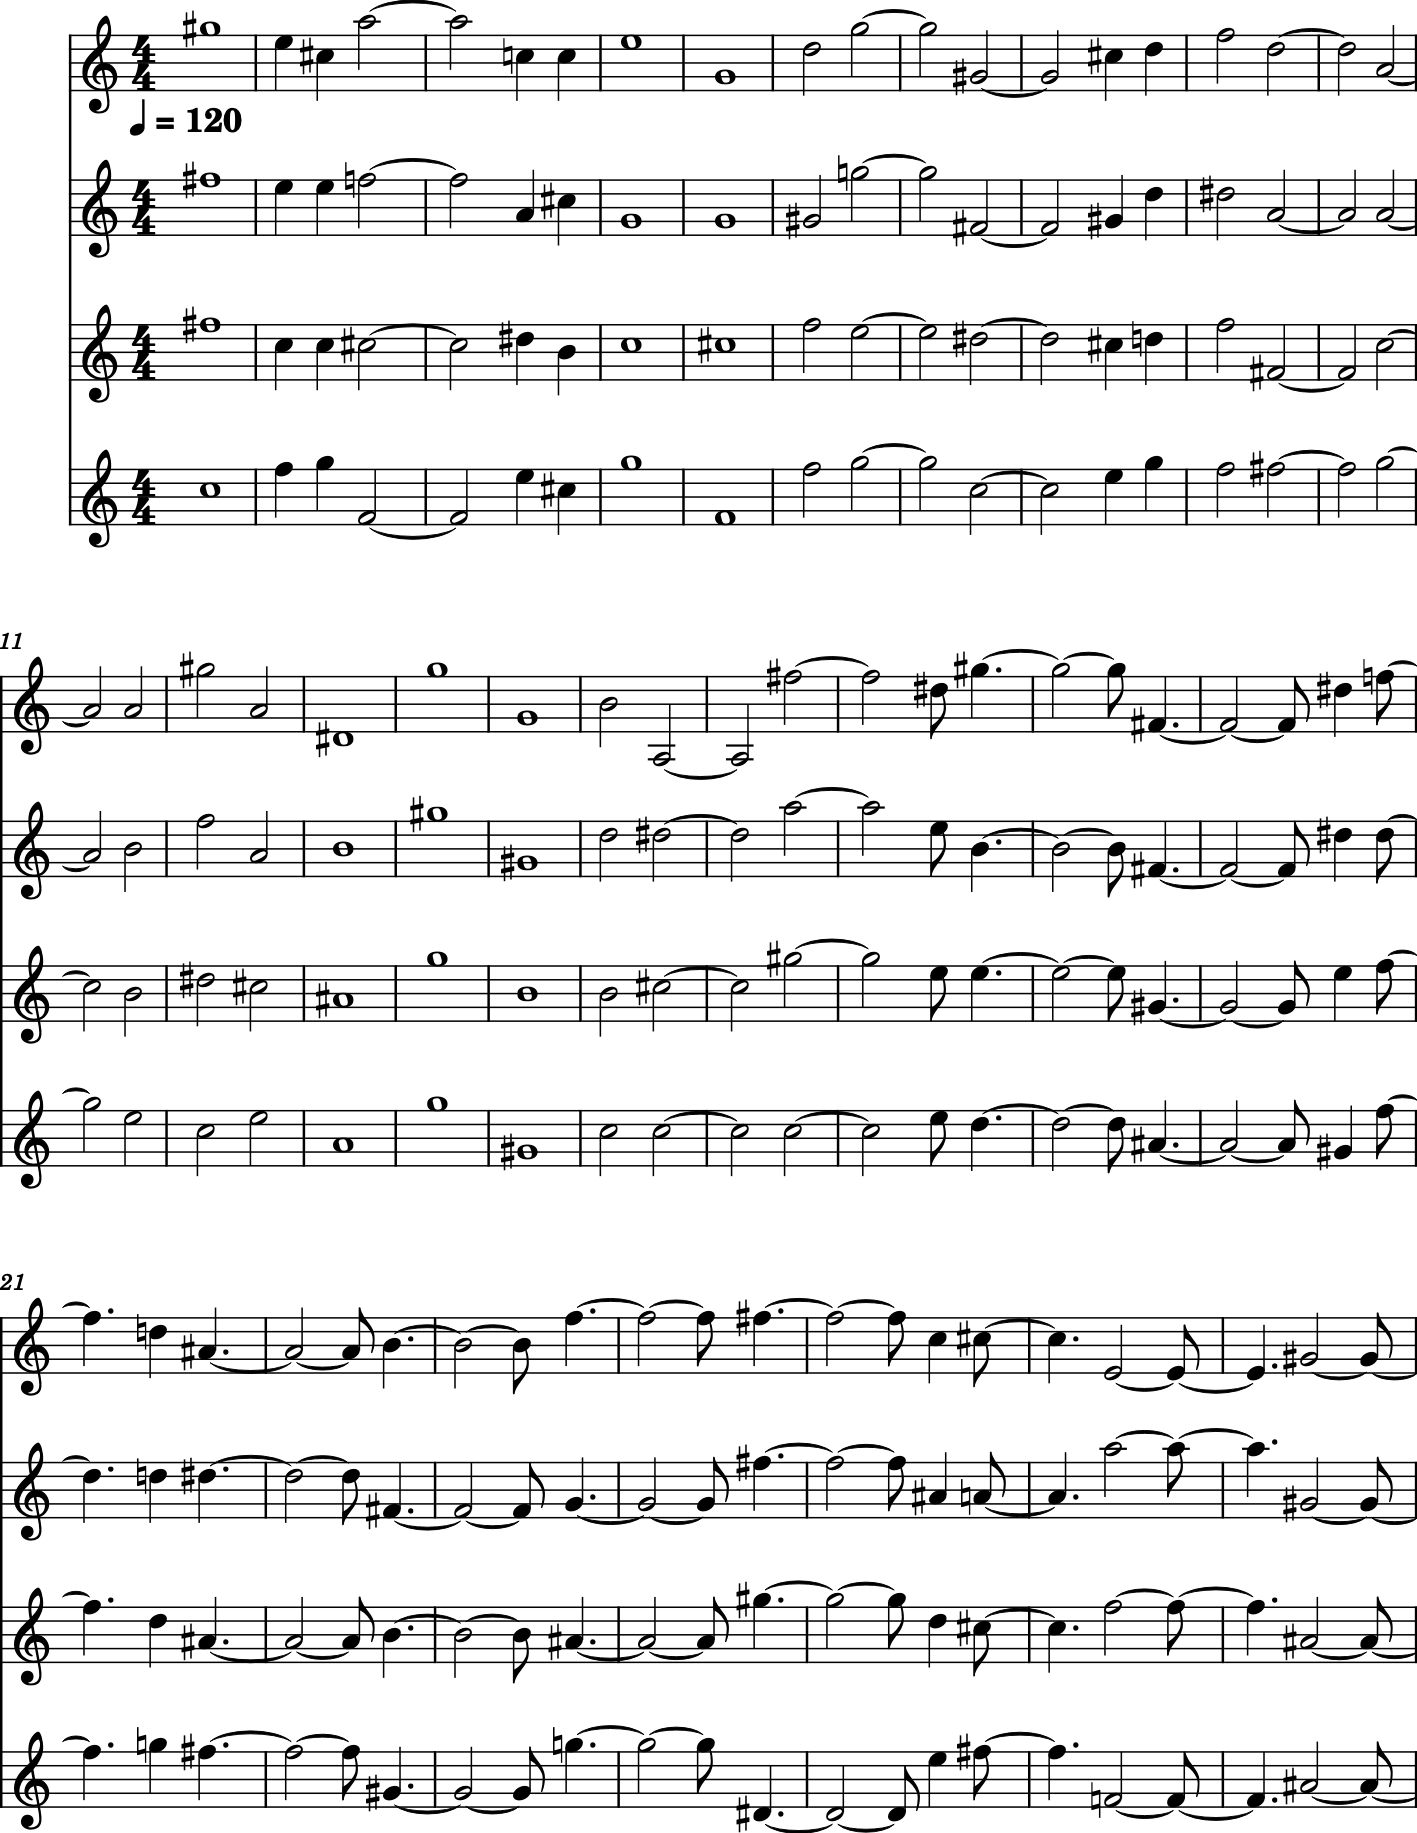

In [62]:
score.show()

In [63]:
score.show('midi')

In [64]:
score.write('midi', fp='Bach_Polyphonic.mid')

'Bach_Polyphonic.mid'

score.show('musicxml')

In [1]:
import session_info
session_info.show()